In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

# import os
# os.chdir('/content/drive/MyDrive/根據區域微氣候資料預測發電量競賽')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
# 讀取 CSV 檔
add = pd.read_csv('ADD_FEATURE.csv')

# 對 Face 欄位進行 One-Hot 編碼
face_encoded_df = pd.get_dummies(add['Face'], drop_first=True, prefix='Face')

# 將新欄位與原始 DataFrame 合併並刪除舊欄位
add = pd.concat([add.drop('Face', axis=1), face_encoded_df], axis=1)
add.head()

,LocationCode,Latitude,Longitude,Height,Face_Northwest,Face_South,Face_Southeast,Face_Southwest,Face_West
0,1,23.8994,121.5444,5,False,True,False,False,False
1,2,23.8997,121.5447,5,False,True,False,False,False
2,3,23.8997,121.5450,5,False,True,False,False,False
3,4,23.8994,121.5444,5,False,True,False,False,False
4,5,23.8994,121.5447,5,False,False,False,True,False


In [ ]:
# 讀取 CSV 檔
df = pd.read_csv('LALL_Train_Revise.csv')
df

In [ ]:
# 割出日期、時間等資訊
df['year'] = df['Serial'].astype(str).str[:4].astype(int)   # 年份
df['month'] = df['Serial'].astype(str).str[4:6].astype(int)  # 月份
df['day'] = df['Serial'].astype(str).str[6:8].astype(int)   # 日期
df['hour'] = df['Serial'].astype(str).str[8:10].astype(int)  # 小時
df['minute'] = df['Serial'].astype(str).str[10:12].astype(int) # 分鐘
df['LocationCode'] = df['Serial'].astype(str).str[12:].astype(int) # 裝置代碼
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])    # 日期
df['weekday'] = df['date'].dt.weekday  # 星期幾 (0 表示星期一，6表示星期日）
df = df.drop(columns=['date'])

In [ ]:
# 季節劃分函數
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

df['Season'] = df['month'].apply(get_season)

# 對 Season 欄位進行 One-Hot 編碼
df = pd.get_dummies(df, columns=['Season'], drop_first=False)

In [ ]:
df = pd.merge(df, add, on='LocationCode', how='left')
df[df.select_dtypes(include='bool').columns] = df.select_dtypes(include='bool').astype(int)
df

# Heatmap


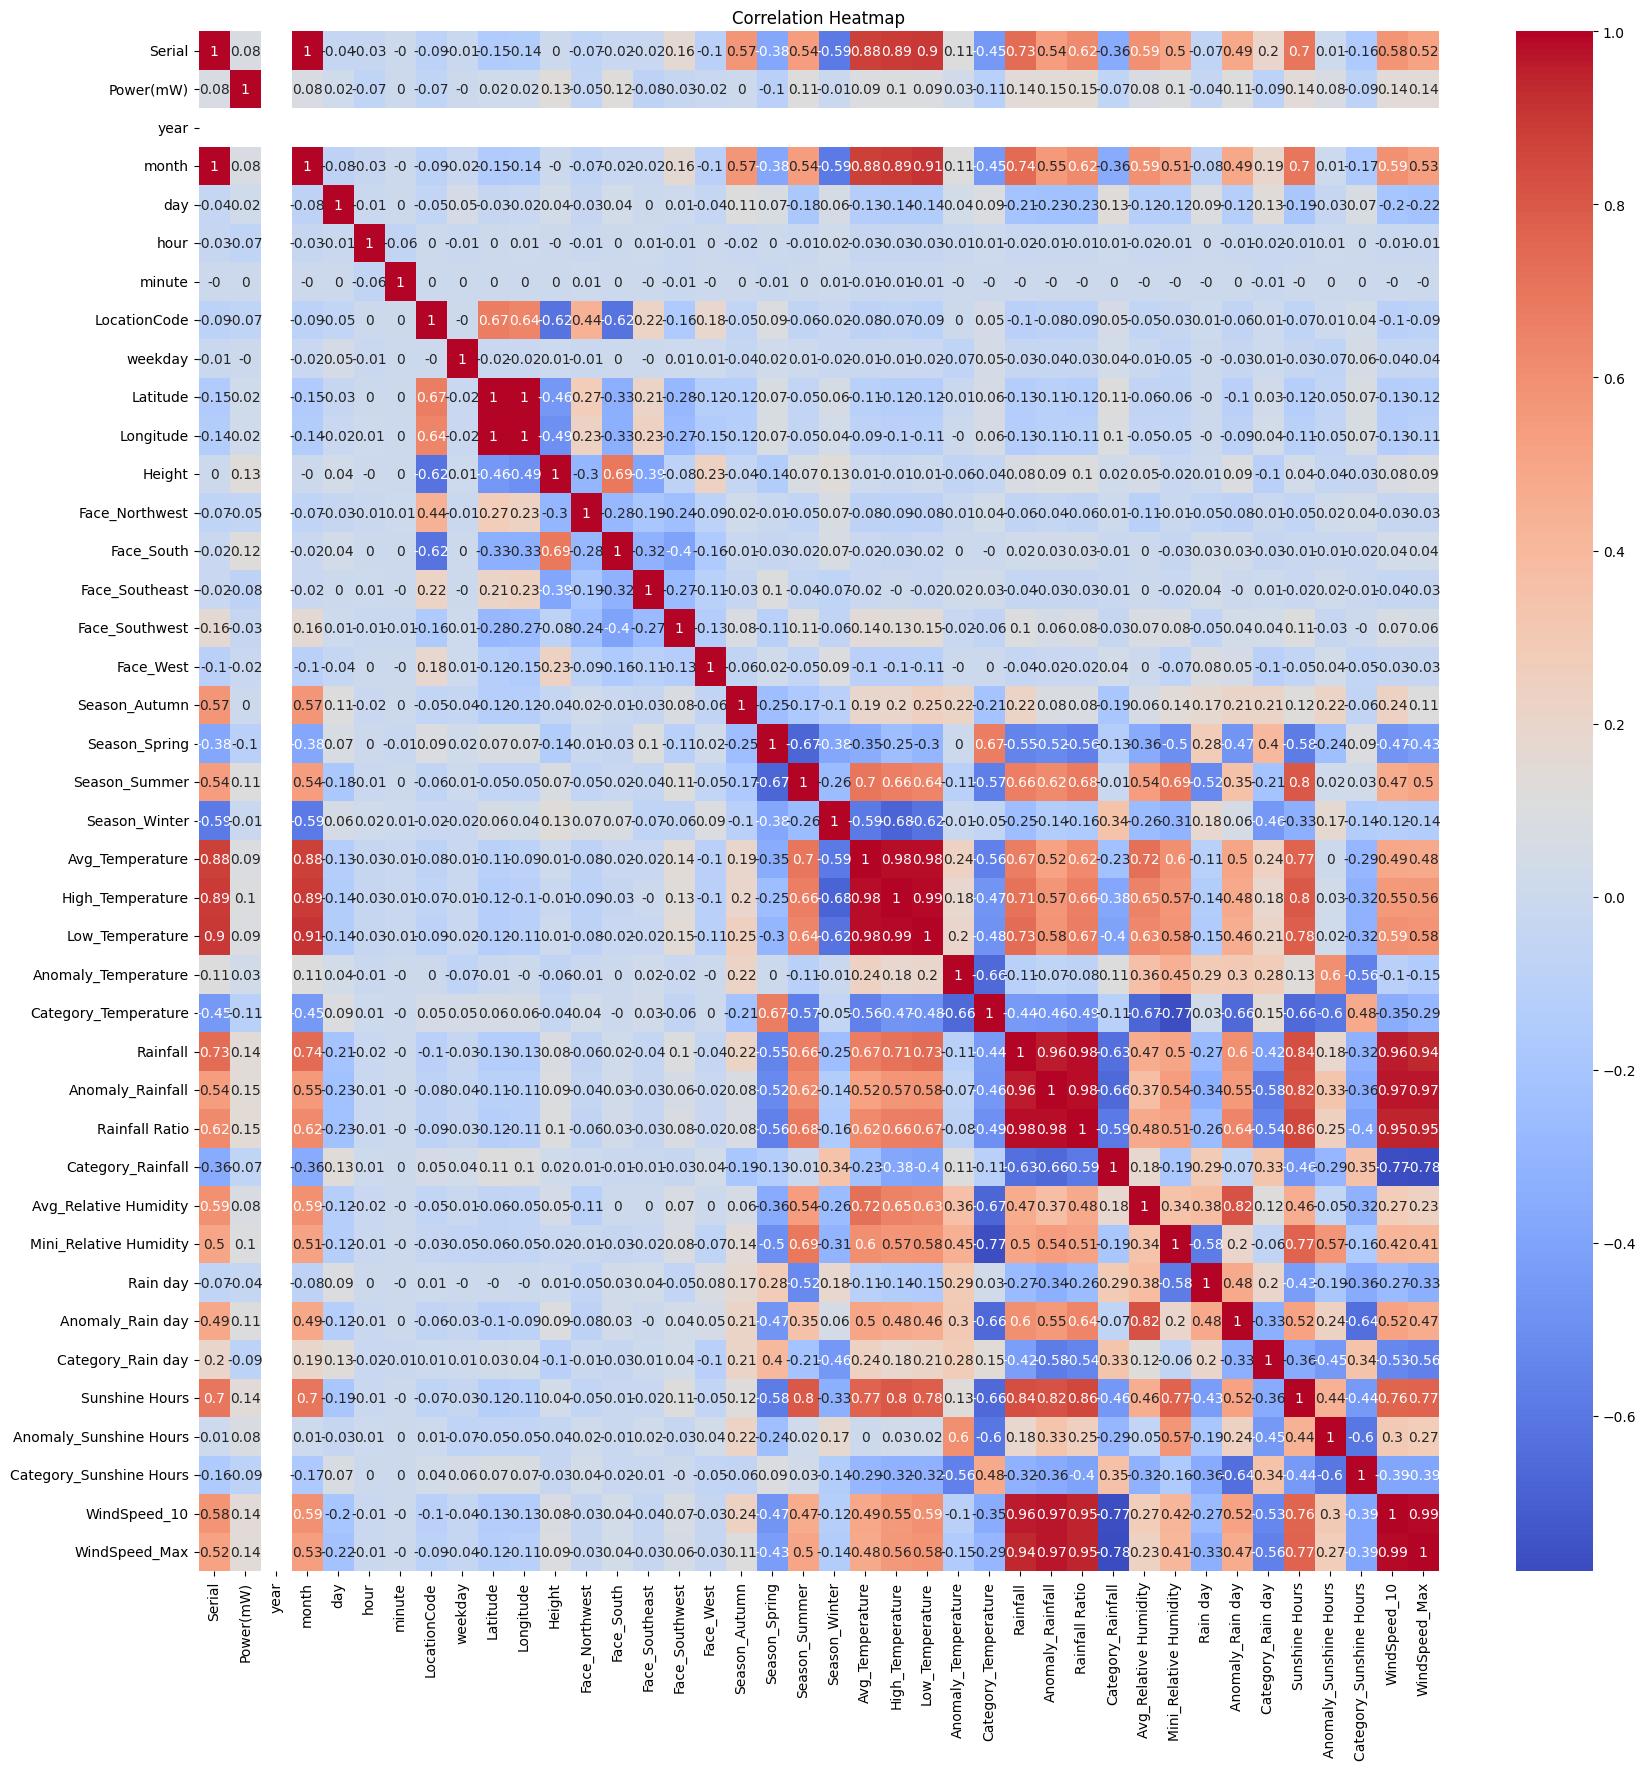

In [ ]:
plt.figure(figsize=(25, 25))
df_test = df.copy()
df_test = df_test.drop(['WindSpeed(m/s)', 'Pressure(hpa)', 'Temperature(°C)', 'Humidity(%)', 'Sunlight(Lux)'], axis=1)
corr_matrix = df_test.corr().round(2)
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
correlation = df_test.corr().abs()
top_features = correlation['Power(mW)'].sort_values(ascending=False).head(20)
top_features

Power(mW)                  1.000000
Rainfall Ratio             0.148629
Anomaly_Rainfall           0.145880
Sunshine Hours             0.143271
Rainfall                   0.138214
WindSpeed_Max              0.136448
WindSpeed_10               0.135274
Height                     0.127759
Face_South                 0.124519
Anomaly_Rain day           0.111529
Category_Temperature       0.109345
Season_Summer              0.106556
Mini_Relative Humidity     0.099866
Season_Spring              0.096463
High_Temperature           0.096312
Category_Rain day          0.094970
Low_Temperature            0.094812
Avg_Temperature            0.092639
Category_Sunshine Hours    0.092637
Serial                     0.081603
Name: Power(mW), dtype: float64

In [ ]:
# 進行訓練資料和測試資料的切割
from sklearn.model_selection import train_test_split

x = df[['Serial' ,'month', 'day', 'hour', 'minute', 'LocationCode' ,'weekday','Latitude' ,'Longitude','Height' ,
    'Face_South' ,'Face_Southeast' ,'Season_Winter' ,'Season_Summer' ,'Season_Spring']] # 使用Feature
y = df['Power(mW)'] # 使用Label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(103131, 15) (34378, 15) (103131,) (34378,)


In [16]:
x_train

,Serial,month,day,hour,minute,LocationCode,weekday,Latitude,Longitude,Height,Face_South,Face_Southeast,Season_Winter,Season_Summer,Season_Spring
16083,20240504124902,5,4,12,49,2,5,23.8997,121.5447,5,1,0,0,0,1
3529,20240301124501,3,1,12,45,1,4,23.8994,121.5444,5,1,0,0,0,1
56864,20240625091008,6,25,9,10,8,1,23.8997,121.5450,3,0,0,0,1,0
131635,20240303164317,3,3,16,43,17,6,23.9933,121.5985,3,0,0,0,0,1
137291,20240710070317,7,10,7,3,17,2,23.9933,121.5985,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,20240705184014,7,5,18,40,14,4,23.8978,121.5394,5,1,0,0,1,0
119879,20240308114316,3,8,11,43,16,4,24.0092,121.6172,1,0,0,0,0,1
103694,20240704091613,7,4,9,16,13,3,23.8978,121.5394,5,0,0,0,1,0
131932,20240308144917,3,8,14,49,17,4,23.9933,121.5985,3,0,0,0,0,1


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# 對訓練集進行擬合並轉換
x_train_scaled = scaler.fit_transform(x_train)

# 對測試集進行轉換（使用已經在訓練集上擬合的標準化參數）
x_test_scaled = scaler.transform(x_test)

# 查看轉換後的數據形狀
print(x_train_scaled.shape, x_test_scaled.shape)

(103131, 15) (34378, 15)


In [18]:
x_train_scaled

array([[ 0.02551069,  0.08118849, -1.31823327, ..., -0.38161851,
        -0.67431492,  1.00158177],
       [-0.96194941, -0.88903745, -1.66210122, ..., -0.38161851,
        -0.67431492,  1.00158177],
       [ 0.61392925,  0.56630146,  1.08884238, ..., -0.38161851,
         1.48298661, -0.99842073],
       ...,
       [ 0.99821393,  1.05141442, -1.31823327, ..., -0.38161851,
         1.48298661, -0.99842073],
       [-0.92779982, -0.88903745, -0.85974267, ..., -0.38161851,
        -0.67431492,  1.00158177],
       [-0.45114162, -0.40392448, -1.08898797, ..., -0.38161851,
        -0.67431492,  1.00158177]])

# Model Building and Evaluation

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

models = [
    ('XGBoost', xgb.XGBRegressor(random_state=42)),
    # ('LightGBM', lgb.LGBMRegressor(random_state=42)),
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('CatBoost', CatBoostRegressor(random_state=42, verbose=0)),
    # ('Lasso', Lasso(random_state=42)),
    ('Ridge', Ridge(random_state=42)),
    # ('ElasticNet', ElasticNet(random_state=42))
]

# 殘差圖函數
def plot_residuals_side_by_side(model, X_train, y_train, X_test, y_test, model_name):
    # 預測訓練集和測試集
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    # 計算訓練和測試的殘差
    train_residuals = y_train - train_predictions
    test_residuals = y_test - test_predictions

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # 訓練集的殘差圖
    sns.residplot(x=train_predictions, y=train_residuals, lowess=True, color='blue', line_kws={'color': 'red', 'lw': 1}, ax=axes[0])
    axes[0].set_title(f'{model_name} Training Set Residuals')
    axes[0].set_xlabel('Predicted Values')
    axes[0].set_ylabel('Residuals')
    # 測試集的殘差圖
    sns.residplot(x=test_predictions, y=test_residuals, lowess=True, color='green', line_kws={'color': 'red', 'lw': 1}, ax=axes[1])
    axes[1].set_title(f'{model_name} Testing Set Residuals')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')
    plt.tight_layout()
    plt.show()

# 評估指標函數
def evaluate_model_with_residuals(model, X_train, y_train, X_test, y_test, model_name='Model'):
    # 訓練集的預測與評估
    train_predictions = model.predict(X_train)
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_mae = mean_absolute_error(y_train, train_predictions)
    # 測試集的預測與評估
    test_predictions = model.predict(X_test)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    print(f'{model_name} Training Set:')
    print(f'R2 Score: {train_r2:.4f}')
    print(f'Mean Squared Error: {train_mse:.4f}')
    print(f'Mean Absolute Error: {train_mae:.4f}\n')
    print(f'{model_name} Testing Set:')
    print(f'R2 Score: {test_r2:.4f}')
    print(f'Mean Squared Error: {test_mse:.4f}')
    print(f'Mean Absolute Error: {test_mae:.4f}\n')

for model_name, model in models:
    print(f'Fitting and evaluating {model_name}...')
    # 訓練模型
    model.fit(x_train_scaled, y_train)
    evaluate_model_with_residuals(model, x_train_scaled, y_train, x_test_scaled, y_test, model_name=model_name)
    # plot_residuals_side_by_side(model, x_train_scaled, y_train, x_test_scaled, y_test, model_name=model_name)
    print('=' * 40)

Fitting and evaluating XGBoost...
XGBoost Training Set:
R2 Score: 0.9040
Mean Squared Error: 20653.6940
Mean Absolute Error: 85.0439

XGBoost Testing Set:
R2 Score: 0.8604
Mean Squared Error: 30249.0629
Mean Absolute Error: 101.6395



In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

#定義基模型
base_models = [
    ('XGBoost', xgb.XGBRegressor(
        booster='gbtree',          # 使用樹模型
        reg_lambda=0.1,            # L2 正則化權重
        alpha=0.1,                # L1 正則化權重
        subsample=0.85,             # 每次迭代的子樣本比例
        colsample_bytree=0.85,      # 每棵樹的特徵子樣本比例
        max_depth=30,              # 決策樹的最大深度
        min_child_weight=5,        # 最小葉子節點樣本權重和
        eta=0.1,                 # 學習率 (別名 learning_rate)
        gamma=0.01,                # 分裂節點的最小損失減益
        grow_policy='depthwise',   # 樹的增長策略，按深度增長
        random_state=42            # 隨機種子，確保結果可重現
    )),
    ('RandomForest', RandomForestRegressor(
        n_estimators=1200,        # 決策樹的數量
        max_depth=50,             # 每棵決策樹的最大深度
        random_state=42,          # 隨機種子，確保結果可重現
    )),
    ('CatBoost', CatBoostRegressor(
        iterations=3000,                  # 最大迭代次數
        depth=10,                         # 樹的深度
        learning_rate=0.048291852388211744,  # 學習率
        l2_leaf_reg=4.265000761781573,    # L2 正則化系數
        bagging_temperature=0.7402703416136728,  # Bagging 溫度參數
        subsample=0.7896228883861611,     # 子樣本比例
        grow_policy="Depthwise",          # 樹的增長策略
        random_state=42,                  # 隨機種子，確保可重現性
        early_stopping_rounds=100,        # 早停條件
        random_strength=0.620821162440965, # 控制特徵分裂得分的隨機性
        verbose=0                         # 禁用訓練日誌
    )),
]
# 最終模型
poly_model = make_pipeline(
    PolynomialFeatures(degree=4),  # 4 or 5
    Ridge(alpha=0.001)             # 正規化強度，嘗試不同的 alpha 值
)
# 堆疊回歸模型
stacking_model = StackingRegressor(estimators=base_models, final_estimator=poly_model, passthrough=True) 

models = [
    ('Stacking', stacking_model)
]

# 訓練模型
def evaluate_and_plot(models, x_train, y_train, x_test, y_test):
    for model_name, model in models:
        print(f'Fitting and evaluating {model_name}...')
        model.fit(x_train, y_train) 
        evaluate_model_with_residuals(model, x_train, y_train, x_test, y_test, model_name=model_name)
        print('=' * 40)
# 評估模型
evaluate_and_plot(models, x_train_scaled, y_train, x_test_scaled, y_test)

Fitting and evaluating Stacking...
Stacking Training Set:
R2 Score: 0.9822
Mean Squared Error: 3822.5798
Mean Absolute Error: 25.7790

Stacking Testing Set:
R2 Score: 0.9332
Mean Squared Error: 14467.4389
Mean Absolute Error: 53.7789



In [ ]:
# poly_model PolynomialFeatures(degree=4), Ridge(alpha=0.001)  
# ('XGBoost', xgb.XGBRegressor(超參數)),('RandomForest', RandomForestRegressor(n_estimators=1200 ,random_state=42 ,max_depth=50)),('CatBoost', CatBoostRegressor(超參數))
# Fitting and evaluating Stacking...
# Stacking Training Set:
# R2 Score: 0.9822
# Mean Squared Error: 3822.5798
# Mean Absolute Error: 25.7790

# Stacking Testing Set:
# R2 Score: 0.9332
# Mean Squared Error: 14467.4389
# Mean Absolute Error: 53.7789
# 143m 18.4s

# Save Model

In [25]:
# # Save modle
# from joblib import dump, load

# # 儲存標準化器
# dump(scaler, 'scaler.joblib')
# # 儲存訓練好的 Stacking 模型
# dump(stacking_model, 'stacking_model.joblib')

# # 加載已儲存的標準化器
# scaler = load('scaler.joblib')
# # 加載已儲存的 Stacking 模型
# loaded_stacking_model = load('stacking_model.joblib')

# new_data_scaled = scaler.transform(x_test)
# predictions = loaded_stacking_model.predict(new_data_scaled)
# predictions[predictions < 0] = 0
# print(np.round(predictions, 2))